# Making the 95th efficiency plots 

In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = 'pt_regress_v1.h5'

2023-06-27 05:07:45.407278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 05:07:45.560671: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-27 05:07:45.565724: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/submit/dhoang/DQ/core-inst/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/s

# First we need to reproduce the efficiency plots but with corrected pT

In [2]:
def plot_pt_eff_puppi(ModelName,
                      Model_Regress,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=1.,
                      cut_point = 0.28):
    '''
    cut_point = 0.28. We accept anything larger than this. 
    The corresponding corrected pT cut is 30 GeV.

    dir_path: directory path where the data is saved,
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model_id = load_model(ModelName)
    model_pt_regress = load_model(Model_Regress)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    ratio_predict = model_pt_regress.predict(np.asarray(sig_input)).flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    #Originally (reco_pt_sig>1.) 

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]

    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model_id.predict(np.nan_to_num(X_sig))

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]

    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Retrained Tau NN (> {})'.format(cut_point))
    print(eff_new_nn_y)
    
    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
    plt.legend(loc = 'center right')
    plt.show()

1523/1523 [==============================] - 1s 472us/step
[0.004313543304638478, 0.01300630508118186, 0.03380765269235343, 0.14005925606476638, 0.4005636642797465, 0.617630011867427, 0.7250864553509564, 0.7748445390654879, 0.8215740718753926, 0.8503594244749597, 0.8711310211006005, 0.8880260957801519, 0.9107602519725253, 0.9230640628651281, 0.9422449319445385, 0.9357849380543207]


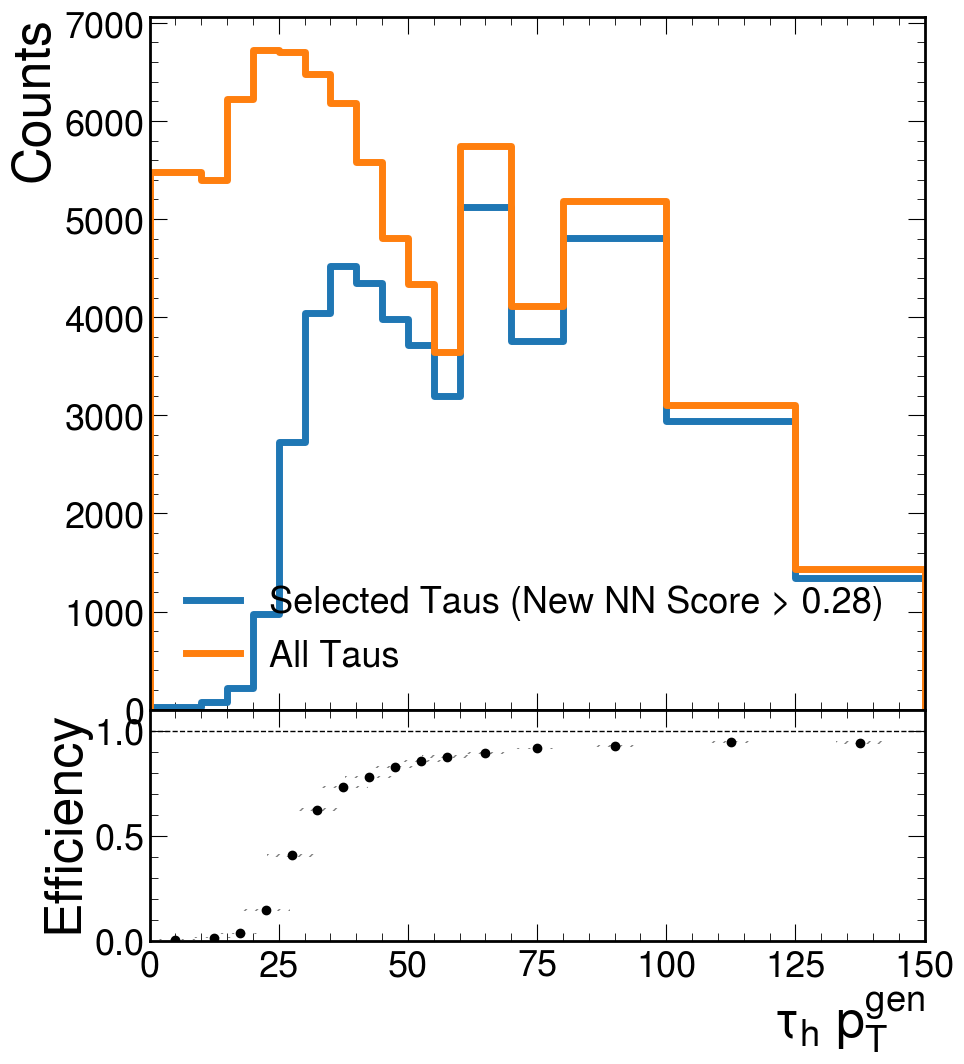

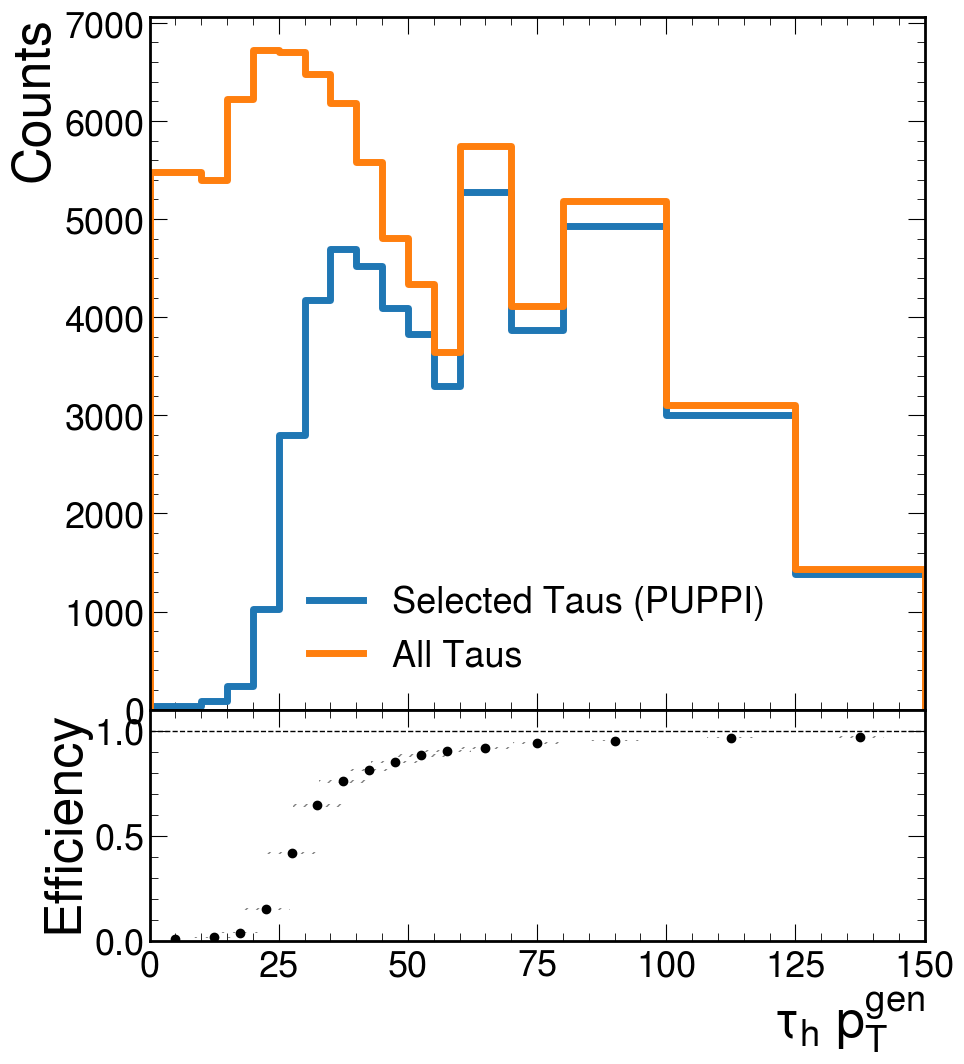

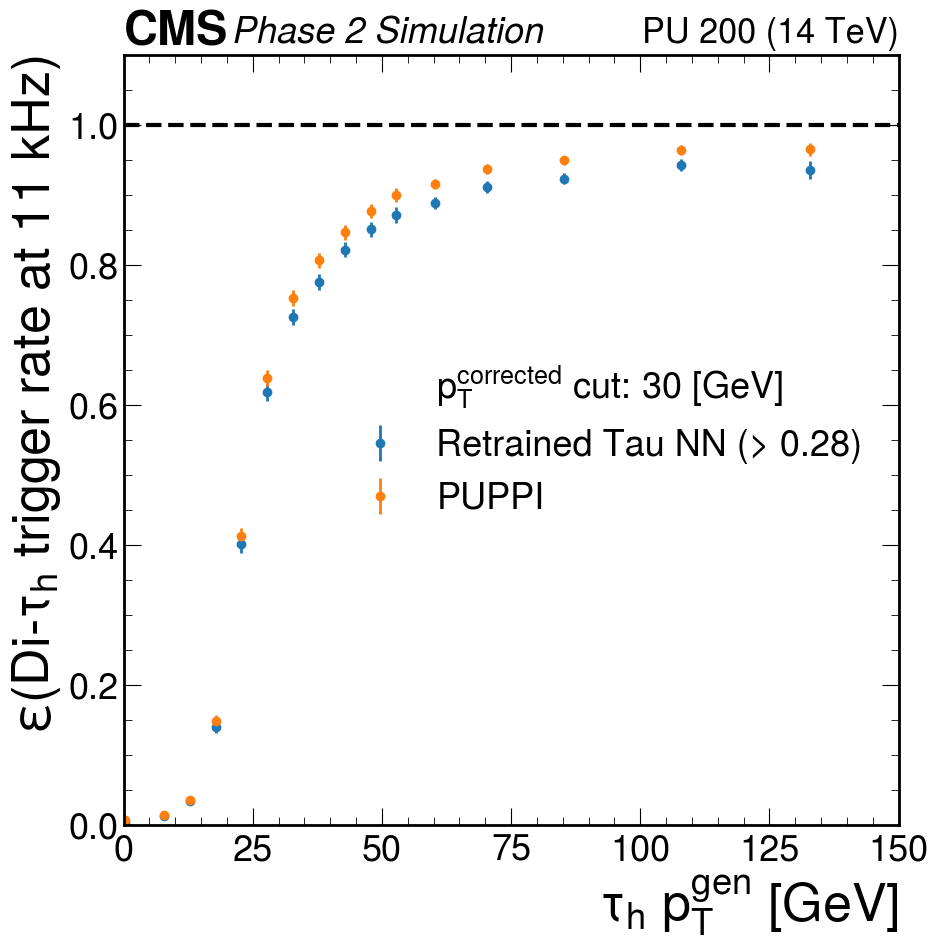

In [5]:
plot_pt_eff_puppi('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=30.,
                            cut_point = 0.28)